# Project Introduction
- _Description: Trong file đồ án này, chúng tôi sẽ huấn luyện 1 vài model (ARIMA, SARIMA, Random Forest) để dự đoán nhiệt độ trung bình trong 30 ngày của 1 trạm khí tượng tại thành phố Toronta, Canada._
- _Link data: [climate weather](https://climate.weather.gc.ca/historical_data/search_historic_data_e.html)_

### Part 1: Thêm thư viện

In [199]:
import os
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

### Part 2: Đọc dữ liệu

In [200]:
# Đọc tệp CSV đã tải lên
file_path = 'preProcessedDataWithHmdx.csv'
data = pd.read_csv(file_path)

# Xóa cột không cần thiết
data = data.drop(columns=['HMDX_label'])

# Hiển thị thông tin cơ bản của dữ liệu
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int64  
 1   Month             3439 non-null   int64  
 2   Day               3439 non-null   int64  
 3   Temp_mean         3439 non-null   float64
 4   DewPoint_mean     3439 non-null   float64
 5   RelHum_mean       3439 non-null   float64
 6   PrecipAmount_sum  3439 non-null   float64
 7   StnPress_mean     3439 non-null   float64
 8   HMDX              3439 non-null   float64
 9   Temp_range        3439 non-null   float64
 10  DewPoint_range    3439 non-null   float64
 11  RelHum_range      3439 non-null   float64
 12  StnPress_range    3439 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 349.4 KB


(None,
    Year  Month  Day  Temp_mean  DewPoint_mean  RelHum_mean  PrecipAmount_sum  \
 0  2015      1    1     -5.092        -12.758       55.125               0.0   
 1  2015      1    2     -1.729         -8.804       59.250               0.0   
 2  2015      1    3     -1.417         -5.121       76.750               8.7   
 3  2015      1    4      2.854          1.988       94.333              13.7   
 4  2015      1    5     -7.196        -12.212       67.833               0.8   
 
    StnPress_mean  HMDX  Temp_range  DewPoint_range  RelHum_range  \
 0         99.931   0.0         4.4             5.0          17.0   
 1        100.519   0.0         2.4             7.9          40.0   
 2        101.142   0.0         4.6            11.2          43.0   
 3         99.089   1.2         3.3             5.9          25.0   
 4        100.647   0.0        11.8            18.1          41.0   
 
    StnPress_range  
 0            0.92  
 1            1.58  
 2            1.64  
 3   

### Part 3:

#### Ma trận Corr để lọc danh sách các cột có thuộc tính tương quan lớn

In [201]:
# Tính ma trận tương quan
correlation_matrix = data.corr()

# Xác định các cặp thuộc tính có tương quan lớn hơn 0.75
high_corr_pairs = correlation_matrix[correlation_matrix.abs() > 0.75].stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]

# Lọc danh sách các cột cần loại bỏ
columns_to_drop = set()
for col1, col2, corr in high_corr_pairs.itertuples(index=False):
    # Chỉ giữ lại một cột trong mỗi cặp
    if col1 not in columns_to_drop:
        columns_to_drop.add(col2)

# Loại bỏ các cột có tương quan cao
filtered_data = data.drop(columns=list(columns_to_drop), axis=1)
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3439 entries, 0 to 3438
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3439 non-null   int64  
 1   Month             3439 non-null   int64  
 2   Day               3439 non-null   int64  
 3   Temp_mean         3439 non-null   float64
 4   RelHum_mean       3439 non-null   float64
 5   PrecipAmount_sum  3439 non-null   float64
 6   StnPress_mean     3439 non-null   float64
 7   Temp_range        3439 non-null   float64
 8   DewPoint_range    3439 non-null   float64
 9   RelHum_range      3439 non-null   float64
 10  StnPress_range    3439 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 295.7 KB


#### Xử lí các cột thời gian

In [202]:
# Kết hợp các cột Year, Month, Day thành một cột Date
filtered_data['Date'] = pd.to_datetime(filtered_data[['Year', 'Month', 'Day']])

# Đặt cột 'Date' làm chỉ số thời gian
filtered_data.set_index('Date', inplace=True)

# Xóa các cột không cần thiết
filtered_data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
filtered_data_no_precip = filtered_data.drop(columns=['PrecipAmount_sum'])

#### Chia tập dữ liệu gốc thành tập huấn luyện và tập kiểm tra

##### Tập kiểm tra

In [203]:
test_data = filtered_data.iloc[-30:]['Temp_mean']

##### Tập huấn luyện có Precip

In [204]:
train_data_precip = filtered_data.iloc[:-30]['Temp_mean']

In [205]:
train_data_precip.head()

Date
2015-01-01   -5.092
2015-01-02   -1.729
2015-01-03   -1.417
2015-01-04    2.854
2015-01-05   -7.196
Name: Temp_mean, dtype: float64

In [206]:
result = adfuller(train_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.5734113117091613
p-value: 0.006290171101920332


##### Tập huấn luyện không có Precip

In [207]:
train_data_no_precip = filtered_data_no_precip.iloc[:-30]['Temp_mean']

In [208]:
train_data_no_precip.head()

Date
2015-01-01   -5.092
2015-01-02   -1.729
2015-01-03   -1.417
2015-01-04    2.854
2015-01-05   -7.196
Name: Temp_mean, dtype: float64

In [209]:
result = adfuller(train_data_no_precip)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.5734113117091613
p-value: 0.006290171101920332


### Part 4: Chạy mô hình

#### Mô hình ARIMA

##### Khai báo các thông số

In [210]:
p, d, q = 2, 4, 5

##### Precip

C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\loca

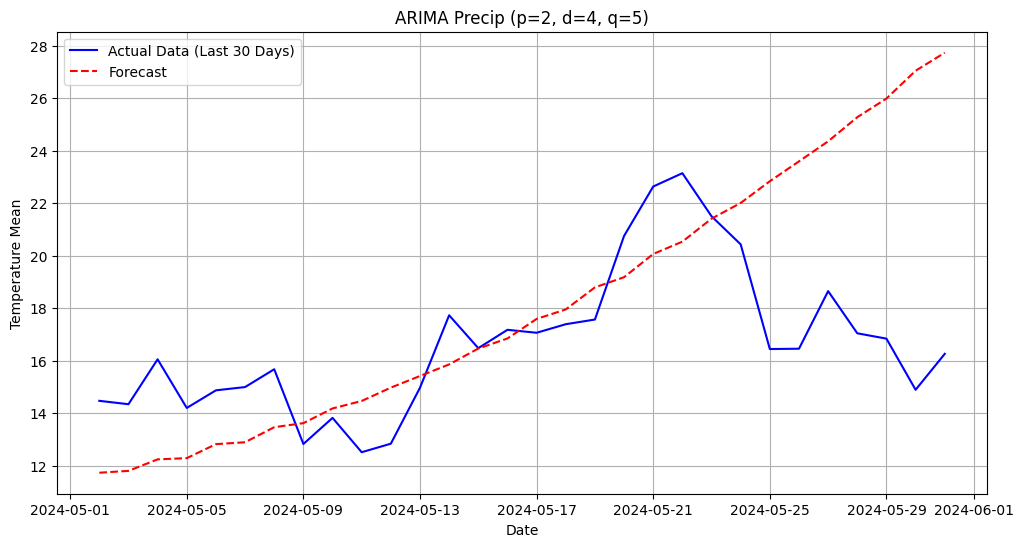

In [211]:
model_precip = ARIMA(train_data_precip, order=(p, d, q))
model_precip_fit = model_precip.fit()

# Dự đoán
forecast_precip = model_precip_fit.forecast(steps=30)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_precip, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'ARIMA Precip (p={p}, d={d}, q={q})')
plt.legend()
plt.grid()

##### Non-Precip

C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\loca

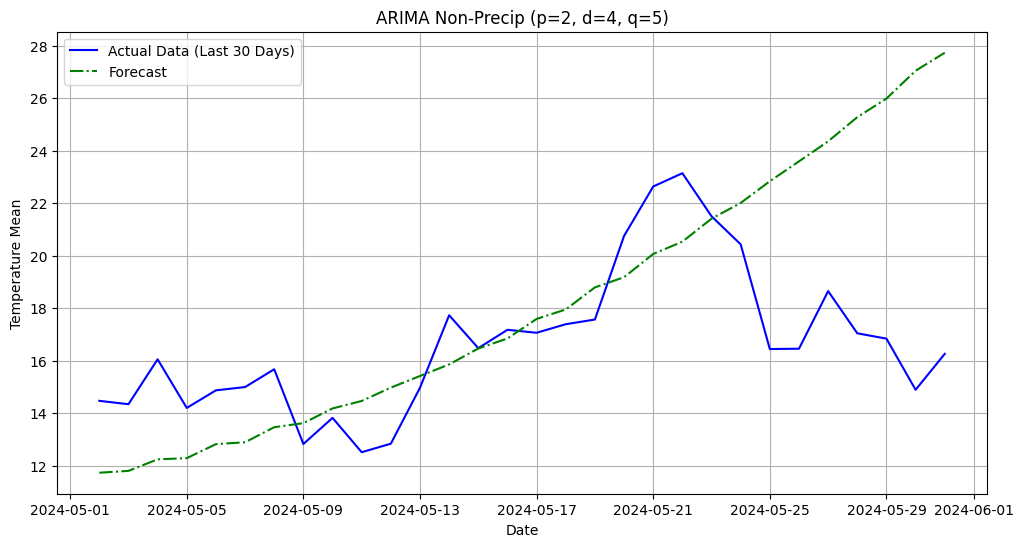

In [212]:
model_no_precip = ARIMA(train_data_no_precip, order=(p, d, q))
model_no_precip_fit = model_no_precip.fit()

# Dự đoán
forecast_no_precip = model_no_precip_fit.forecast(steps=30)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_no_precip, label='Forecast', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'ARIMA Non-Precip (p={p}, d={d}, q={q})')
plt.legend()
plt.grid()

##### So sánh

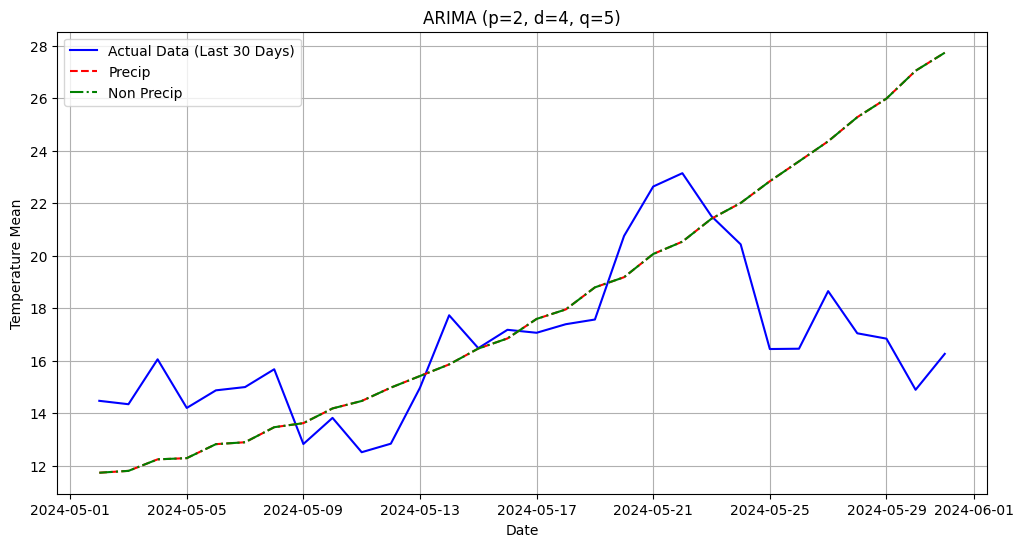

In [213]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_precip, label='Precip', color='red', linestyle='--')
plt.plot(test_data.index, forecast_no_precip, label='Non Precip', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'ARIMA (p={p}, d={d}, q={q})')
plt.legend()
plt.grid()

#### Mô hình SARIMA

##### Khai báo các thông số

In [214]:
p, d, q, P, D, Q, S = 2, 2, 1, 1, 1, 0, 4

##### Precip

C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


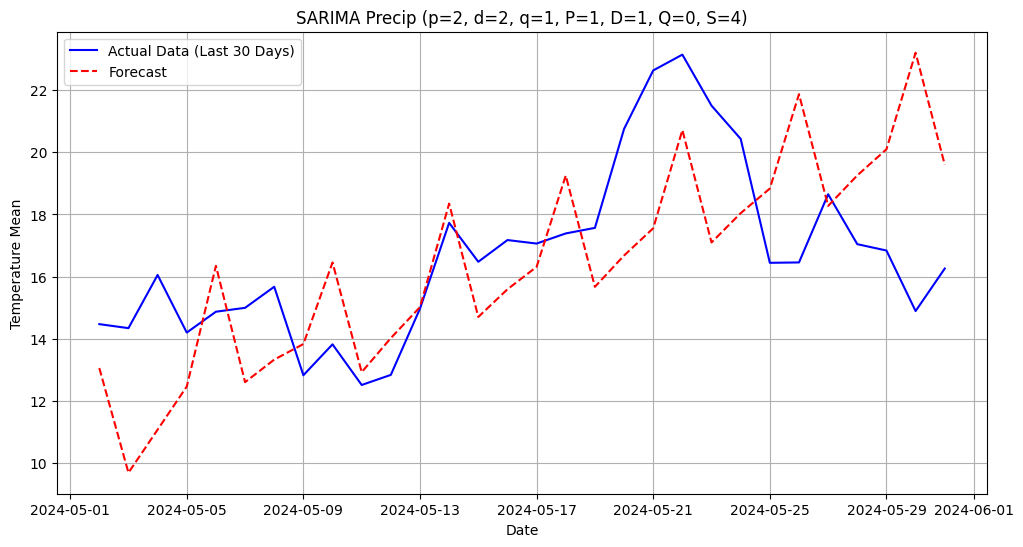

In [215]:
sarima_model_precip = SARIMAX(train_data_precip, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_model_precip_fit = sarima_model_precip.fit()

# Dự đoán
forecast_sarima_precip = sarima_model_precip_fit.forecast(steps=30)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_sarima_precip, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'SARIMA Precip (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
plt.legend()
plt.grid()

##### Non-Precip

C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\sonsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


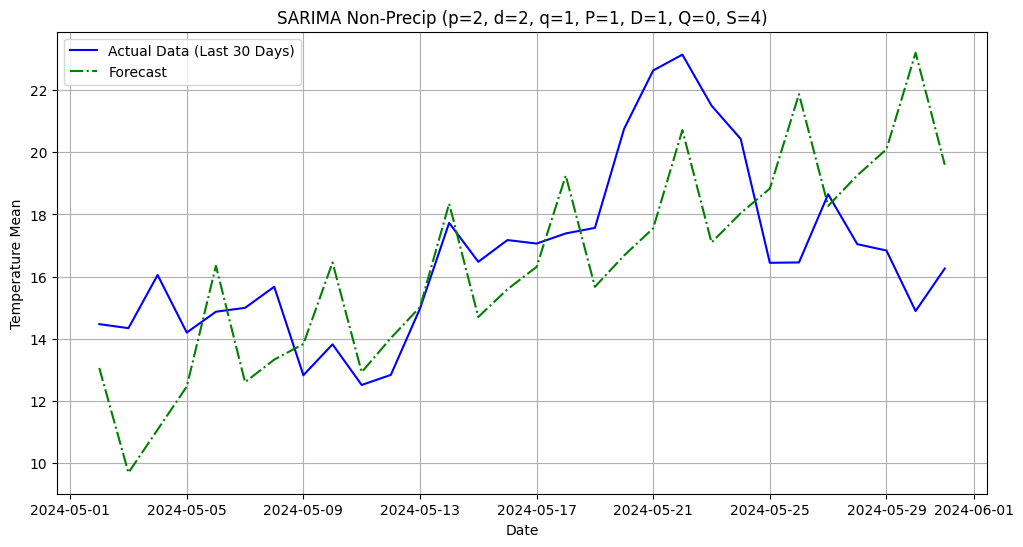

In [216]:
sarima_model_no_precip = SARIMAX(train_data_no_precip, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_model_no_precip_fit = sarima_model_no_precip.fit()

# Dự đoán
forecast_sarima_no_precip = sarima_model_no_precip_fit.forecast(steps=30)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_sarima_no_precip, label='Forecast', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'SARIMA Non-Precip (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S})')
plt.legend()
plt.grid()

##### So sánh

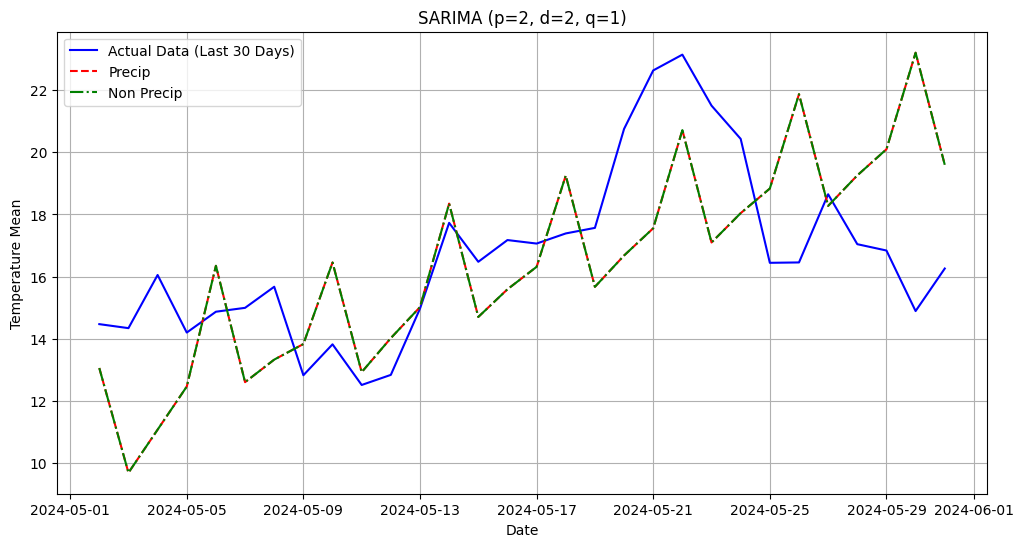

In [217]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_sarima_precip, label='Precip', color='red', linestyle='--')
plt.plot(test_data.index, forecast_sarima_no_precip, label='Non Precip', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title(f'SARIMA (p={p}, d={d}, q={q})')
plt.legend()
plt.grid()

#### Mô hình Random Forest

##### Chuẩn bị dữ liệu

In [218]:
target_column='Temp_mean'
# Tạo X và y
X = filtered_data.drop(columns=[target_column])
y = filtered_data[target_column]

# Hiển thị kích thước của X và y
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_precip, X_test, y_train_precip, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Tạo X và y cho tập không có Precip
X_no_precip = filtered_data_no_precip.drop(columns=[target_column])
y_no_precip = filtered_data_no_precip[target_column]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho tập không có Precip
X_train_no_precip, X_test_no_precip, y_train_no_precip, y_test_no_precip = train_test_split(X_no_precip, y_no_precip, test_size=0.1, random_state=42, shuffle=False)

X shape: (3439, 7)
y shape: (3439,)


##### Precip

MSE Precip: 47.8071646415535


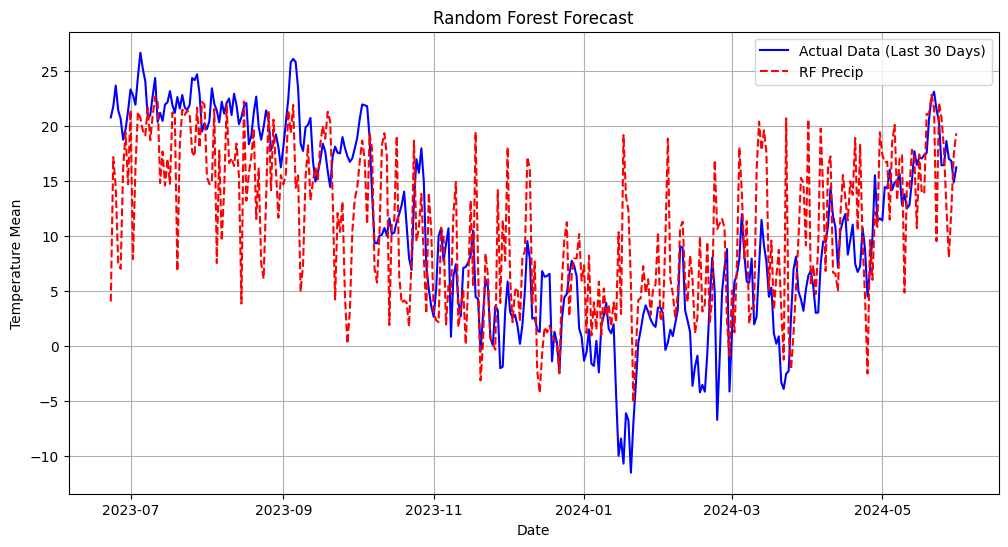

In [219]:
# Huấn luyện mô hình
rf_model_precip = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_precip.fit(X_train_precip, y_train_precip)

# Dự đoán
forecast_rf_precip = rf_model_precip.predict(X_test)

# Tính toán lỗi
mse_precip = mean_squared_error(y_test, forecast_rf_precip)
print(f'MSE Precip: {mse_precip}')

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(y_test.index, forecast_rf_precip, label='RF Precip', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title('Random Forest Forecast')
plt.legend()
plt.grid()
plt.show()

##### Non-Precip

MSE No Precip: 47.92528050082064


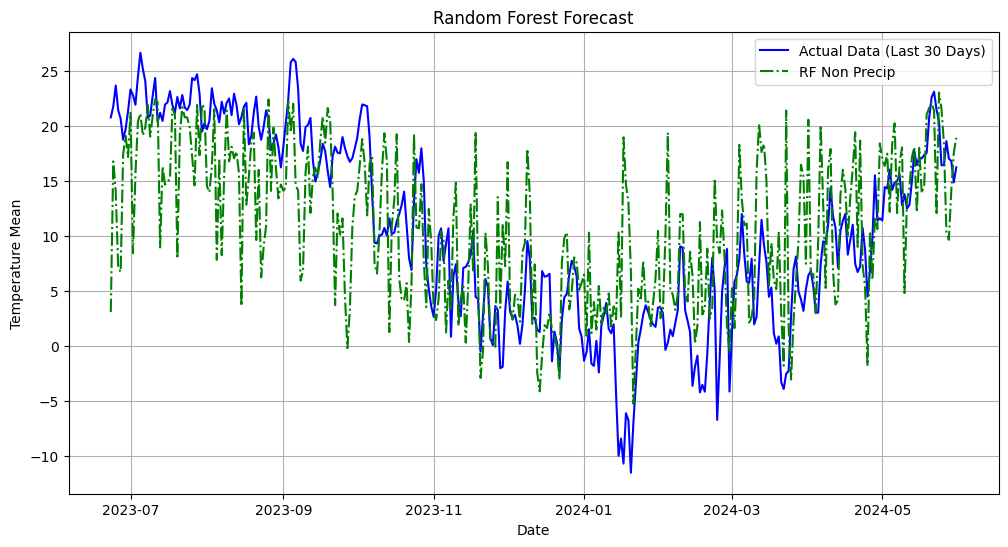

In [220]:
# Huấn luyện mô hình
rf_model_no_precip = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_no_precip.fit(X_train_no_precip, y_train_no_precip)

# Dự đoán
forecast_rf_no_precip = rf_model_no_precip.predict(X_test_no_precip)

# Tính toán lỗi
mse_no_precip = mean_squared_error(y_test_no_precip, forecast_rf_no_precip)
print(f'MSE No Precip: {mse_no_precip}')

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(y_test_no_precip.index, y_test_no_precip, label='Actual Data (Last 30 Days)', color='blue')
plt.plot(y_test_no_precip.index, forecast_rf_no_precip, label='RF Non Precip', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title('Random Forest Forecast')
plt.legend()
plt.grid()
plt.show()

##### So sánh

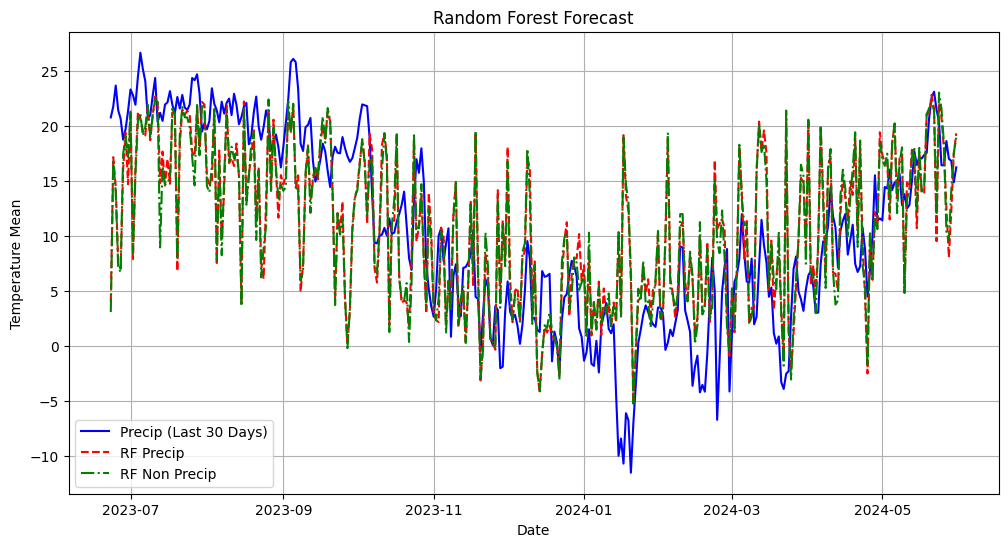

In [223]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Precip (Last 30 Days)', color='blue')
plt.plot(y_test.index, forecast_rf_precip, label='RF Precip', color='red', linestyle='--')
plt.plot(y_test.index, forecast_rf_no_precip, label='RF Non Precip', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Temperature Mean')
plt.title('Random Forest Forecast')
plt.legend()
plt.grid()
plt.show()